In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import glob

In [47]:
paths = glob.glob("./dataset/labels/*.txt")
labels = []

for path in paths:
    boxes = []
    with open(path) as f:
        while True:
            s = f.readline()
            if not s:
                break

            label, cx, cy, dx, dy = [float(x) for x in s.split(" ")]

            x1 = int((cx - dx / 2) * W)
            x2 = int((cx + dx / 2) * W)

            y1 = int((cy - dy / 2) * H)
            y2 = int((cy + dy / 2) * H)

            bbox = [x1, y1, x2, y2]
            boxes.append(bbox)

    labels.append(boxes)

In [53]:
paths = glob.glob("./dataset/images/*")

for i in range(len(paths)):
    img = cv2.imread(paths[i])
    if img is not None:
        for j in range(len(images[i])):
            x1, y1, x2, y2 = images[i][j]
            img_2 = img[y1:y2, x1:x2]
            cv2.imwrite(os.path.join("./dataset/croped_images/" , str(i) + '_' + str(j) + '.jpg'), img_2)

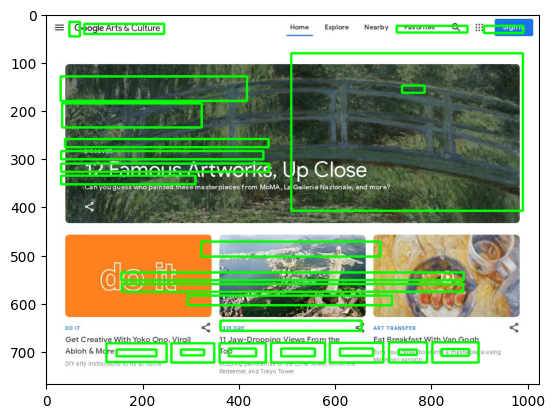

In [46]:
img = cv2.imread('./dataset/images/d004cc80-artsandculture_google_com_png.rf.a5edb02118f118e15be41468a2903fa1.jpg')
for bbox in images[0]:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

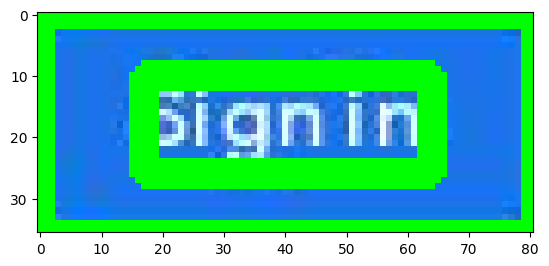

In [41]:
for bbox in boxes:
    x1, y1, x2, y2 = bbox
    img_2 = img[y1:y2, x1:x2]
    plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
    break

In [19]:
H, W, C = img.shape

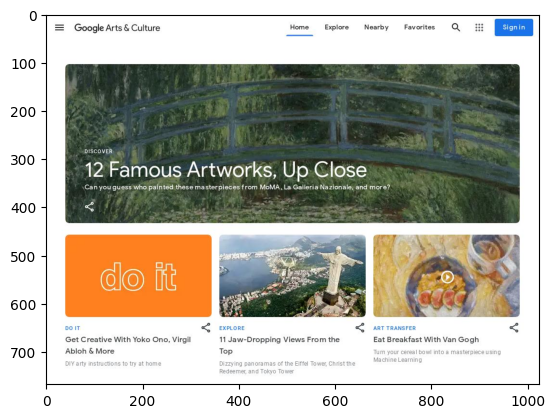

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Siamese Neural Network Dataset

In [3]:
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()


class SiameseTriplet(Dataset):
    
    def __init__(self, 
                 imageFolderDataset,  
                 mid_transforms = None,
                 wid_transforms = None,
                 heg_transforms = None,
                 positive_transforms=None):
        
        self.paths = glob.glob(imageFolderDataset)
        self.imageFolderDataset = imageFolderDataset
        self.mid_transforms = mid_transforms 
        self.wid_transforms = wid_transforms
        self.heg_transforms = heg_transforms
        self.positive_transforms = positive_transforms

    def __getitem__(self,index):
        while True:
            anchor_path = random.choice(self.paths)
            anchor = Image.open(anchor_path).convert("RGB")

            width, height = anchor.size
            
            if (width > height) and (abs(width - height) < 10):
                break

        while True:
            negative_path = random.choice(self.paths)
            negative = Image.open(negative_path).convert("RGB")

            neg_width, neg_height = negative.size
            if (anchor_path != negative_path) and (neg_width > neg_height) and (abs(neg_width - neg_height) < 10):
                break

        if self.positive_transforms is not None:
            positive = self.positive_transforms(anchor)

        anchor = self.wid_transforms(anchor)
        positive = self.wid_transforms(positive)
        negative = self.wid_transforms(negative)

        return anchor, positive, negative

    def __len__(self):
        return len(self.paths)

In [5]:
# anchor, positive and negative sample

training_dir = "./dataset/croped_images/*"
train_batch_size = 64
train_number_epochs = 100

mid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()
])

wid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 224)),
    torchvision.transforms.ToTensor()
])

heg_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 128)),
    torchvision.transforms.ToTensor()
])

positive_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(hue=.05),
    torchvision.transforms.RandomGrayscale(p=0.1)
])

siamese_dataset = SiameseTriplet(imageFolderDataset=training_dir, 
                                 mid_transforms = mid_transforms,
                                 wid_transforms = wid_transforms,
                                 heg_transforms = heg_transforms, 
                                 positive_transforms=positive_transforms)

vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=1)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[0]), 0)

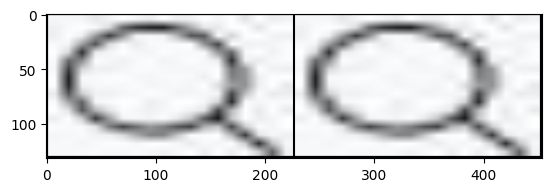

In [477]:
plt.imshow(np.transpose(torchvision.utils.make_grid(concatenated).numpy(), (1, 2, 0)))

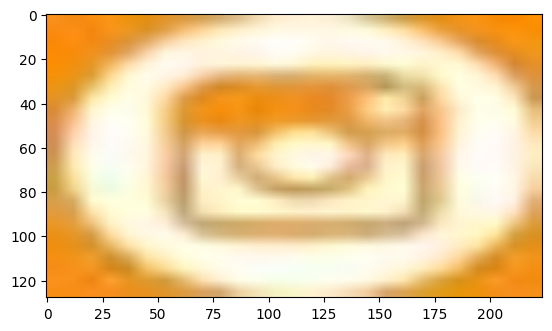

In [478]:
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.cat((example_batch[2],), 0)).numpy(), (1, 2, 0)))

### Siamese neural network

In [6]:
import torchvision.utils
import numpy as np
import random
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as frames

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32,64,kernel_size=3,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),          

            nn.Conv2d(128,256,kernel_size=1,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),

            nn.Conv2d(256,256,kernel_size=1,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),  

            nn.Conv2d(256,512,kernel_size=3,stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),    

            nn.Conv2d(512,1024,kernel_size=1,stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024)
            )


    def forward_once(self, x):
        output = self.net(x)
        
        output = torch.squeeze(output)
        return output

    def forward(self, input1, input2, input3=None):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        if input3 is not None:
            output3 = self.forward_once(input3)
            return output1, output2, output3

        return output1, output2

In [8]:
class TripletLoss(nn.Module):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = F.cosine_similarity(anchor,positive) 
        distance_negative = F.cosine_similarity(anchor,negative)
        losses = (1 - distance_positive)**2 + (0 - distance_negative)**2
        return losses.mean() if size_average else losses.sum()

In [9]:
from scipy.stats import multivariate_normal

def get_gaussian_mask(width, height):
    x, y = np.mgrid[0:1.0:height, 0:1.0:width]
    xy = np.column_stack([x.flat, y.flat])
    mu = np.array([0.9,0.9])
    sigma = np.array([0.5,1])
    covariance = np.diag(sigma**2) 
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance) 
    z = z.reshape(x.shape) 

    z = z / z.max()
    z  = z.astype(np.float32)

    mask = torch.from_numpy(z)

    return mask

#getting training data and Siamese network
GPU compute available:  True
#sarting training
iteration no 0 Epoch number 0
 Current loss 0.05179093778133392

iteration no 10 Epoch number 0
 Current loss 0.021889135241508484

iteration no 20 Epoch number 0
 Current loss 0.02478078007698059

iteration no 30 Epoch number 0
 Current loss 0.016620807349681854

iteration no 40 Epoch number 0
 Current loss 0.015237288549542427

iteration no 50 Epoch number 0
 Current loss 0.022782033309340477

iteration no 60 Epoch number 0
 Current loss 0.0153641477227211

iteration no 70 Epoch number 0
 Current loss 0.014663167297840118

iteration no 80 Epoch number 0
 Current loss 0.011141572147607803

iteration no 90 Epoch number 0
 Current loss 0.006833232473582029

iteration no 0 Epoch number 1
 Current loss 0.008262933231890202

iteration no 10 Epoch number 1
 Current loss 0.01753212884068489

iteration no 20 Epoch number 1
 Current loss 0.011187827214598656

iteration no 30 Epoch number 1
 Current loss 0

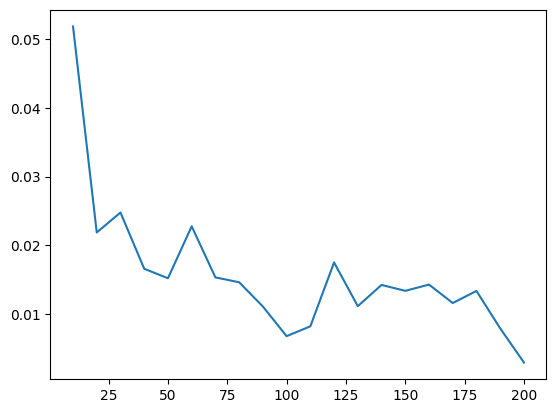

In [480]:
print("#getting training data and Siamese network")
siamese_dataset = SiameseTriplet(imageFolderDataset=training_dir, 
                                 mid_transforms = mid_transforms,
                                 wid_transforms = wid_transforms,
                                 heg_transforms = heg_transforms, 
                                 positive_transforms=positive_transforms)

net = SiameseNetwork().cuda()

criterion = TripletLoss(margin=1)
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

print("GPU compute available: ", torch.cuda.is_available())

counter = []
loss_history = [] 
iteration_number= 0

train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=train_batch_size) # PyTorch data parser obeject

print("#sarting training")
train_number_epochs = 2
for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        anchor, positive, negative = data
        anchor, positive, negative = anchor.cuda(), positive.cuda() , negative.cuda()
        
        _, c, w, h = anchor.shape
        gaussian_mask = get_gaussian_mask(w, h).cuda()
        positive = positive*gaussian_mask

        optimizer.zero_grad()

        anchor_out, positive_out, negative_out = net(anchor, positive, negative)

        triplet_loss = criterion(anchor_out, positive_out, negative_out)
        triplet_loss.backward()
        optimizer.step()

        if i%10 == 0:
            print("iteration no {} Epoch number {}\n Current loss {}\n".format(i,epoch,triplet_loss.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(triplet_loss.item())

show_plot(counter,loss_history)

In [492]:
torch.save(net, './model_deep/1.pt')

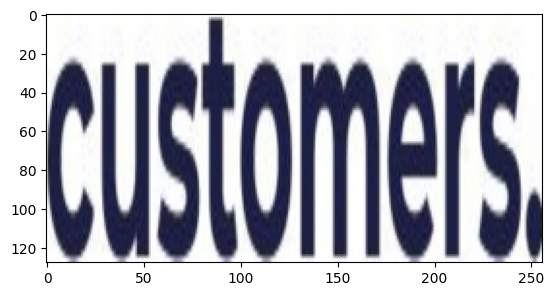

In [389]:
plt.imshow(np.transpose(torchvision.utils.make_grid((anchor.cpu())).numpy(), (1, 2, 0)))

### SNN TEST

In [13]:
from tqdm import tqdm
test_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=1)
dataiter = iter(test_dataloader)
total = len(siamese_dataset)
total_correct = 0
correct = 0
net = torch.load('./model_deep/1.pt')

for i in tqdm(range(total-1)):
    anc, pos, negatives = next(dataiter)
    batch_correct = 0

    for j in range(len(negatives)):
        neg = negatives[j]
        neg = neg.unsqueeze(0)
        _, c, w, h = anc.shape
        gaussian_mask = get_gaussian_mask(w, h).cuda()

        concatenated = torch.cat((anc,pos,neg),0)
        output1, output2, output3 = net(Variable(anc).cuda()*gaussian_mask, Variable(pos).cuda()*gaussian_mask, Variable(neg).cuda()*gaussian_mask)

        output1 = torch.flatten(output1)
        output2 = torch.flatten(output2)
        output3 = torch.flatten(output3)

        output1 = torch.unsqueeze(output1,0)
        output2 = torch.unsqueeze(output2,0)
        output3 = torch.unsqueeze(output3,0)

        d1 = F.cosine_similarity(x1=output1, x2=output2)
        d2 = F.cosine_similarity(x1=output1, x2=output3)

        if d1 > d2:
            batch_correct+=1
            total_correct+=1

    if batch_correct == len(negatives):
        correct+=1


print('correct: ',correct)
print('completely correct batches % ',correct/(total))

print('Total correct examples: ',total_correct)
print('examplewise correct % ',total_correct/(total*len(negatives)))

100%|██████████████████████████████████████████████████████████████████████████████| 5767/5767 [02:51<00:00, 33.67it/s]

correct:  5765
completely correct batches %  0.9994798890429958
Total correct examples:  5765
examplewise correct %  0.9994798890429958


### Deep Sort

In [9]:
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.tracker import Tracker 
from deep_sort.application_util import preprocessing as prep
from deep_sort.application_util import visualization
from deep_sort.deep_sort.detection import Detection

import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision
from scipy.stats import multivariate_normal

In [10]:
class deepsort_rbc():
    def __init__(self,wt_path='./model_deep/1.pt'):
        self.encoder = torch.load(wt_path)

        self.encoder = self.encoder.cuda()
        self.encoder = self.encoder.eval()
        print("Deep sort model loaded from path: ", wt_path)

        self.metric = nn_matching.NearestNeighborDistanceMetric("cosine",.5 , 100)
        self.tracker= Tracker(self.metric)

        self.gaussian_mask = get_gaussian_mask(128, 128).cuda()


        self.transforms = torchvision.transforms.Compose([ \
                torchvision.transforms.ToPILImage(),\
                torchvision.transforms.Resize((128,128)),\
                torchvision.transforms.ToTensor()]
        )


    def pre_process(self,frame,detections):	

        transforms = torchvision.transforms.Compose([ \
            torchvision.transforms.ToPILImage(),\
            torchvision.transforms.Resize((128,128)),\
            torchvision.transforms.ToTensor()])

        crops = []
        for d in detections:

            for i in range(len(d)):
                if d[i] <0:
                    d[i] = 0

            img_h,img_w,img_ch = frame.shape

            xmin, ymin, xmax, ymax, score = d
            w = xmax - xmin
            h = ymax - ymin

            if xmin > img_w:
                xmin = img_w

            if ymin > img_h:
                ymin = img_h

            try:
                crop = frame[ymin:ymax,xmin:xmax,:]
                crop = transforms(crop)
                crops.append(crop)
            except:
                continue

        crops = torch.stack(crops)
        return crops


    def run_deep_sort(self, frame, out_boxes):

        if out_boxes==[]:
            self.tracker.predict()
            print('No detections')
            trackers = self.tracker.tracks
            return trackers

        processed_crops = self.pre_process(frame, out_boxes).cuda()
        processed_crops = self.gaussian_mask * processed_crops

        features = self.encoder.forward_once(processed_crops)
        features = features.detach().cpu().numpy()

        if len(features.shape)==1:
            features = np.expand_dims(features,0)

        dets = []
        for det, feat in zip(out_boxes, features):
            x1, y1, x2, y2, score = det
            bbox = [x1, y1, x2-x1, y2-y1]
            dets.append(Detection(bbox, score, feat))

        outboxes = np.array([d.tlwh for d in dets])

        outscores = np.array([d.confidence for d in dets])
        indices = prep.non_max_suppression(outboxes, 0.8, outscores)

        dets = [dets[i] for i in indices]

        self.tracker.predict()
        self.tracker.update(dets)

        return self.tracker

### Tracking

In [11]:
import sys
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2,pickle,sys
from ultralytics import YOLO

from deep_sort import *
from scipy.stats import multivariate_normal

In [14]:
def track():
    vid_filename = './Запись для трекинга.mp4'
    save_format = '{frame},{id},{x1},{y1},{w},{h},{s},1,-1,-1,-1\n'

    cap = cv2.VideoCapture(vid_filename)
    ret, frame = cap.read()
    H, W, _ = frame.shape

    #initialize deepsort and yolo
    print("Constructing YOLO V8")
    model = YOLO("./best_SGD_100ep.pt")
    print("YOLO V8 Constructed")

    #deepsort
    print("Initializing DeepSort with Siamese Network")
    deepsort = deepsort_rbc(wt_path = './model_deep/1.pt')
    frame_id = 1

    # for output
    video_path_out = 'Результат_deep_sort.mp4'
    out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))
    threshold = 0.25
    count = 1
    
    with open("tracking_res_deep.txt", 'w') as tr:
        while ret:
            ret, frame = cap.read()

            results = model(frame)

            for result in results:
                detections = []
                j = 0
                for result in result.boxes.data.tolist():
                    x1, y1, x2, y2, score, class_id = result
                    x1, y1, x2, y2, class_id = int(x1), int(y1), int(x2), int(y2), int(class_id)

                    if score > threshold:
                        detections.append([x1, y1, x2, y2, score])
                        j += 1


            tracker = deepsort.run_deep_sort(frame, detections)

            for track in tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue

                bbox = track.to_tlbr() 
                id_num = str(track.track_id) 
                features = track.features 
                
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                line = save_format.format(frame=count, id=int(id_num), x1=x1, y1=y1, w=x2-x1, h=y2-y1, s=1)
                tr.write(line)

                cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 2)
                cv2.putText(frame, str(id_num),(int(bbox[0]), int(bbox[1])),0, 5e-3 * 200, (0,255,0),2)

            out.write(frame)
            frame_id+=1
            count += 1
            if count == 125:
                break

        cap.release()
        out.release()
        cv2.destroyAllWindows()

In [15]:
track()

Constructing YOLO V8
YOLO V8 Constructed
Initializing DeepSort with Siamese Network
Deep sort model loaded from path:  ./model_deep/1.pt


Ultralytics YOLOv8.0.20  Python-3.10.0 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)
Model summary (fused): 168 layers, 11128680 parameters, 0 gradients, 28.5 GFLOPs


In [16]:
import motmetrics as mm
# load ground truth
gt = np.loadtxt("ground_truth.txt", delimiter=',')

# load tracking output
t = np.loadtxt("tracking_res_deep.txt", delimiter=',')

acc = mm.MOTAccumulator(auto_id=True)

for frame in range(int(gt[:,0].max())):
    frame += 1

    gt_dets = gt[gt[:,0]==frame,1:6]
    t_dets = t[t[:,0]==frame,1:6]

    C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], \
                                max_iou=0.5)

    acc.update(gt_dets[:,0].astype('int').tolist(), \
              t_dets[:,0].astype('int').tolist(), C)

    mh = mm.metrics.create()

    summary = mh.compute(acc, metrics=['num_frames', 'idf1', 'idp', 'idr', \
                                     'recall', 'precision', 'num_objects', \
                                     'mostly_tracked', 'partially_tracked', \
                                     'mostly_lost', 'num_false_positives', \
                                     'num_misses', 'num_switches', \
                                     'num_fragmentations', 'mota', 'motp' \
                                    ], \
                      name='acc')

    strsummary = mm.io.render_summary(
      summary,
      namemap={'idf1': 'IDF1', 'idp': 'IDP', 'idr': 'IDR', 'recall': 'Rcll', \
               'precision': 'Prcn', 'num_objects': 'GT', \
               'mostly_tracked' : 'MT', 'partially_tracked': 'PT', \
               'mostly_lost' : 'ML', 'num_false_positives': 'FP', \
               'num_misses': 'FN', 'num_switches' : 'IDsw', \
               'num_fragmentations' : 'FM', 'mota': 'MOTA', 'motp' : 'MOTP',  \
              }
    )
    print(strsummary)

     num_frames  IDF1  IDP  IDR  Rcll  Prcn   GT  MT  PT   ML  FP   FN  IDsw  FM  MOTA  MOTP
acc           1   0.0  NaN  0.0   0.0   NaN  109   0   0  109   0  109     0   0   0.0   NaN
     num_frames  IDF1  IDP  IDR  Rcll  Prcn   GT  MT  PT   ML  FP   FN  IDsw  FM  MOTA  MOTP
acc           2   0.0  NaN  0.0   0.0   NaN  218   0   0  109   0  218     0   0   0.0   NaN
     num_frames      IDF1       IDP       IDR      Rcll      Prcn   GT  MT  PT  ML  FP   FN  IDsw  FM    MOTA      MOTP
acc           3  0.375309  0.974359  0.232416  0.232416  0.974359  327   0  76  33   2  251     0   0  0.2263  0.115906
     num_frames      IDF1       IDP       IDR      Rcll      Prcn   GT  MT  PT  ML  FP   FN  IDsw  FM      MOTA     MOTP
acc           4  0.512648  0.968153  0.348624  0.348624  0.968153  436   0  76  33   5  284     0   0  0.337156  0.11538
     num_frames      IDF1       IDP       IDR      Rcll      Prcn   GT  MT  PT  ML  FP   FN  IDsw  FM     MOTA      MOTP
acc           5  0.583867

acc          67  0.727448  0.89107  0.614593  0.641126  0.929539  7387  67  13  35  359  2651    33  59  0.58806  0.125728
     num_frames      IDF1      IDP       IDR      Rcll      Prcn    GT  MT  PT  ML   FP    FN  IDsw  FM     MOTA      MOTP
acc          68  0.726957  0.89022  0.614297  0.641371  0.929455  7498  67  13  35  365  2689    33  59  0.58829  0.125789
     num_frames      IDF1       IDP       IDR      Rcll      Prcn    GT  MT  PT  ML   FP    FN  IDsw  FM      MOTA     MOTP
acc          69  0.726269  0.889037  0.613878  0.641477  0.929006  7609  67  14  34  373  2728    33  59  0.588119  0.12581
     num_frames      IDF1       IDP       IDR      Rcll      Prcn    GT  MT  PT  ML   FP    FN  IDsw  FM      MOTA      MOTP
acc          70  0.725657  0.888056  0.613472  0.641969  0.929308  7720  67  14  34  377  2764    35  62  0.588601  0.125925
     num_frames      IDF1       IDP       IDR      Rcll      Prcn    GT  MT  PT  ML   FP    FN  IDsw  FM      MOTA     MOTP
acc      

acc         100  0.71776  0.871068  0.61034  0.649615  0.92712  11025  67  14  34  563  3863    61  96  0.593016  0.129178
     num_frames     IDF1       IDP       IDR      Rcll     Prcn     GT  MT  PT  ML   FP    FN  IDsw  FM      MOTA      MOTP
acc         101  0.71774  0.870852  0.610418  0.649753  0.92697  11135  67  14  34  570  3900    62  98  0.592995  0.129346
     num_frames      IDF1      IDP       IDR      Rcll      Prcn     GT  MT  PT  ML   FP    FN  IDsw   FM      MOTA     MOTP
acc         102  0.717721  0.87064  0.610494  0.650156  0.927204  11245  67  14  34  574  3934    62  101  0.593597  0.12948
     num_frames      IDF1       IDP       IDR     Rcll      Prcn     GT  MT  PT  ML   FP    FN  IDsw   FM    MOTA      MOTP
acc         103  0.717702  0.870433  0.610568  0.65055  0.927433  11355  67  14  34  578  3968    63  102  0.5941  0.129559
     num_frames      IDF1      IDP       IDR     Rcll      Prcn     GT  MT  PT  ML   FP    FN  IDsw   FM      MOTA      MOTP
acc   